## Neural Network Project: Constructing a CNN Auto-Encoder for Traffic Data Imputation

#### 1. Installing packages

In [ ]:
pip install tensorflow tensorflow-datasets

#### 2. Importing libraries

In [24]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D, Conv2DTranspose, BatchNormalization

#### 3. Loading images from directory into tf.Dataset

In [5]:
## Building the image data set
train = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Missing', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 365, image_size = (200, 200), shuffle = False)
target = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Filled', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 365, image_size = (200, 200), shuffle = False)

Found 512 files belonging to 1 classes.
Found 512 files belonging to 1 classes.


#### 4. Image data preprocessing

In [6]:
## Scaling the data to be between 0 and 1
train = train.map(lambda x:(x/255))
target = target.map(lambda x:(x/255))

In [8]:
## Converting tf.Dataset objects to numpy arrays
def dataset_to_numpy(ds):
    images = []
    for i, image in enumerate(tfds.as_numpy(ds)): 
        images.append(image)
    return np.array(images)

t_size = int(len(train) * 0.75)
v_size = int(len(train) * 0.25)

X_train = dataset_to_numpy(train)[0:t_size]; Y_train = dataset_to_numpy(target)[0:t_size]
X_val = dataset_to_numpy(train)[t_size:(t_size + v_size)]; Y_val = dataset_to_numpy(target)[t_size:(t_size + v_size)]

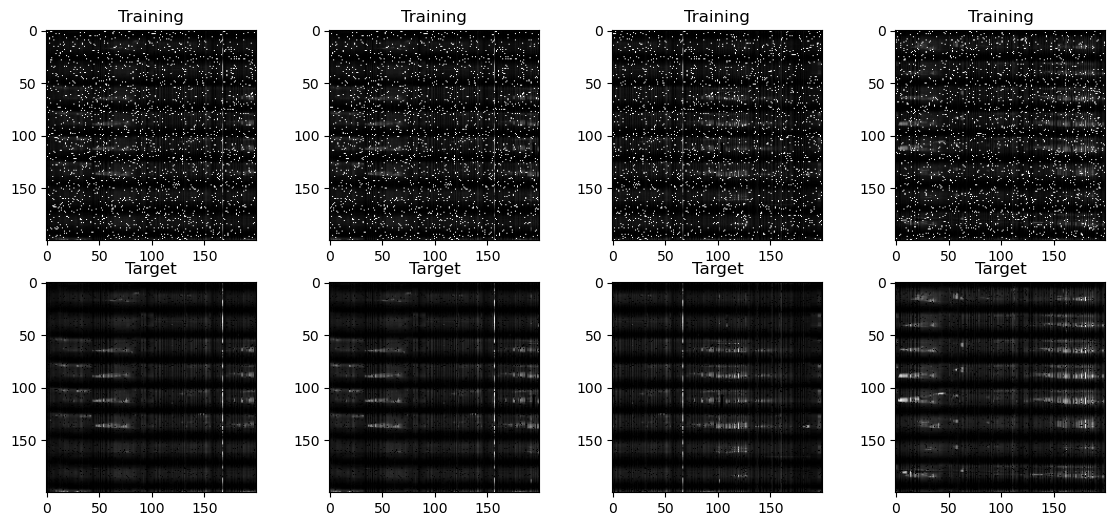

In [9]:
## Visualizing four sample training images 
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (14,6))
for i in range(4):
    ax[0, i].imshow(X_train[i], cmap = 'gray'); ax[0, i].title.set_text('Training')
    ax[1, i].imshow(Y_train[i], cmap = 'gray'); ax[1, i].title.set_text('Target')

#### 5. Constructing the auto-encoder architecture

In [161]:
## Defining the Sequential model
autoencoder = Sequential(name = 'Autoencoder')

## Input Layer
autoencoder.add(Input(shape=(200, 200, 1), name = 'Input'))

## Convo-Pooling Layer 1
autoencoder.add(Conv2D(20, (9,9), 1, data_format = 'channels_last', name = 'Conv_1'))
autoencoder.add(MaxPooling2D(pool_size = (4,4), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_1'))

## Convo-Pooling Layer 2
autoencoder.add(Conv2D(60, (9,9), 1, data_format = 'channels_last', name = 'Conv_2'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_2'))

## Convo-Pooling Layer 3
autoencoder.add(Conv2D(180, (9,9), 1, data_format = 'channels_last', name = 'Conv_3'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_3'))

## Fully-Connected Layer
autoencoder.add(Dense(18, activation = 'relu', name = 'Dense_1', use_bias = False))
autoencoder.add(Dense(180, activation = 'relu', name = 'Dense_2', use_bias = False))

## Up Convo-Pooling Layer 1
autoencoder.add(UpSampling2D(size = (2,2), data_format = 'channels_last', name = 'Up_Max_1'))
autoencoder.add(Conv2DTranspose(180, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_1'))

##Up Convo-Pooling Layer 2
autoencoder.add(UpSampling2D(size = (2,2), data_format = 'channels_last', name = 'Up_Max_2'))
autoencoder.add(Conv2DTranspose(60, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_2'))

## Up Convo-Pooling Layer 3
autoencoder.add(UpSampling2D(size = (4,4), data_format = 'channels_last', name = 'Up_Max_3'))
autoencoder.add(Conv2DTranspose(20, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_3'))

## Output Layer
autoencoder.add(Conv2D(1, (3, 3), activation = 'relu', padding = 'same',  data_format = 'channels_last', name = 'Output'))

In [157]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [158]:
def l2_imputation_loss(y_true, y_pred):
    # y_imp = get_image
    y_pred = np.where()
    mse = np.mean((y_true - y_pred)**2)
    return mse

In [162]:
## Compiling the Sequential model
autoencoder.compile(optimizer = 'adam', loss = tf.losses.MeanSquaredError())

## Printing a model summary
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 192, 192, 20)      1640      
                                                                 
 Max_1 (MaxPooling2D)        (None, 48, 48, 20)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 40, 40, 60)        97260     
                                                                 
 Max_2 (MaxPooling2D)        (None, 20, 20, 60)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 12, 12, 180)       874980    
                                                                 
 Max_3 (MaxPooling2D)        (None, 6, 6, 180)         0         
                                                                 
 Dense_1 (Dense)             (None, 6, 6, 18)          

In [155]:
import numpy as np

#### 6. Fitting the autoencoder model

In [163]:
autoencoder.fit(X_train, Y_train, epochs = 1, batch_size = None, shuffle = True, validation_data = (X_val, Y_val))

12/12 [==============================] - 83s 7s/step - loss: 70.5720 - val_loss: 0.0060


#### 7. Predicting on the testing data

In [166]:
decoded_val_images = autoencoder.predict(X_val)

4/4 [==============================] - 13s 3s/step


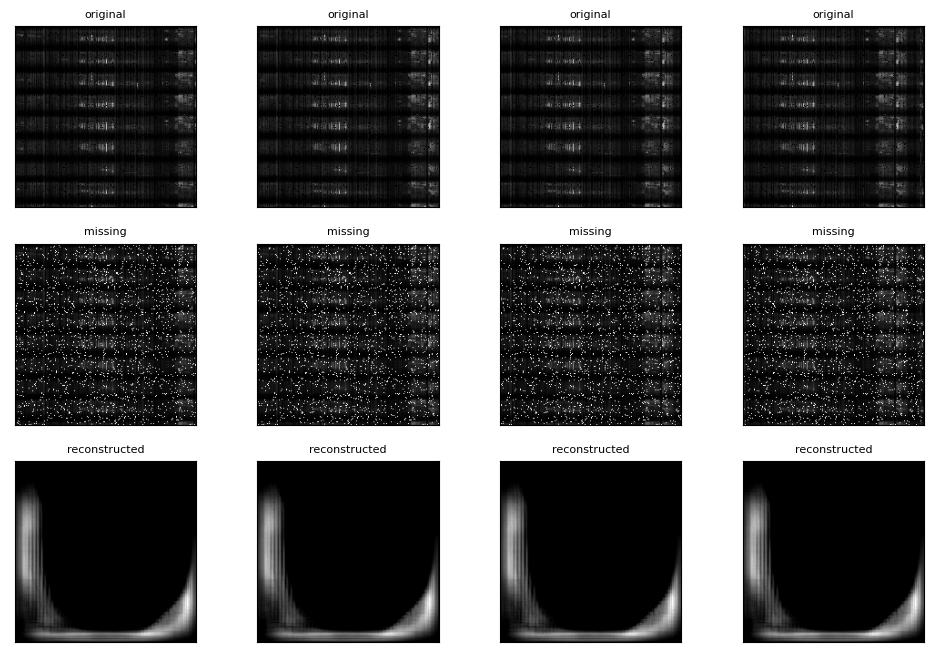

In [175]:
n = 4
plt.figure(figsize=(12, 8))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(tf.squeeze(Y_val[i]), cmap = 'gray')
    plt.title("original", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display missing
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(tf.squeeze(X_val[i]), cmap = 'gray')
    plt.title("missing", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + (2*n))
    plt.imshow(tf.squeeze(decoded_val_images[i]), cmap = 'gray')
    plt.title("reconstructed", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

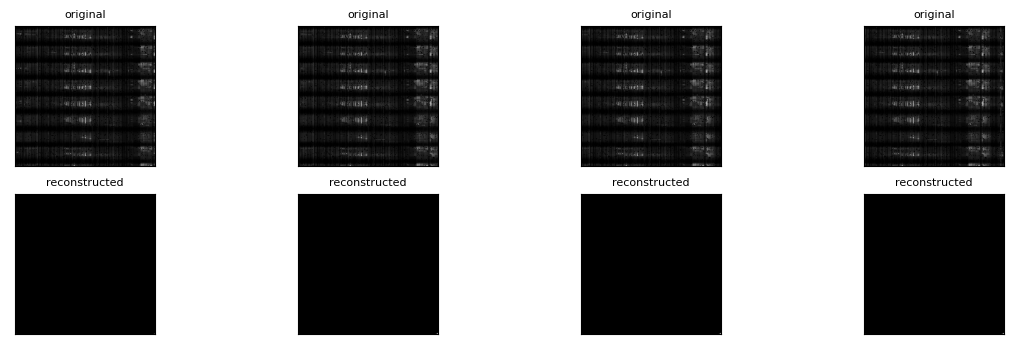

In [135]:
decoded_val_images_new = decoded_val_images*255

n = 4
plt.figure(figsize=(14, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(Y_val[i]), cmap = 'gray')
    plt.title("original", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(decoded_val_images_new[i]), cmap = 'gray')
    plt.title("reconstructed", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [136]:
print(decoded_val_images.max())
print(Y_val.max())

0.27378353
0.78431374


In [143]:
decoded_val_images[10].max()

0.2664234

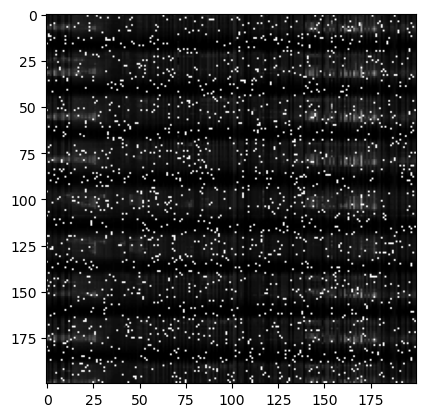

In [147]:
plt.imshow(X_val[10], cmap = 'gray')
plt.show()

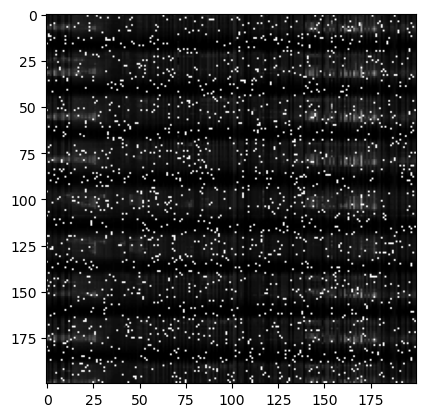

In [146]:
plt.imshow(tf.squeeze(X_val[10]), cmap = 'gray')
plt.show()

In [138]:
decoded_val_images[0]

array([[[1.06379218e-01],
        [1.31915882e-02],
        [1.23868044e-03],
        ...,
        [2.33553257e-03],
        [2.55259946e-02],
        [1.27663165e-01]],

       [[2.93281488e-02],
        [9.06543690e-04],
        [2.68386830e-05],
        ...,
        [1.70439180e-05],
        [1.18953665e-03],
        [2.70562507e-02]],

       [[8.16559326e-03],
        [5.95193414e-05],
        [4.19607886e-07],
        ...,
        [1.26489041e-07],
        [2.49834738e-05],
        [3.37663339e-03]],

       ...,

       [[3.13500431e-03],
        [2.88886204e-05],
        [1.05795465e-07],
        ...,
        [7.19582374e-07],
        [4.98453701e-05],
        [4.95368009e-03]],

       [[2.07458306e-02],
        [8.02035560e-04],
        [2.25225594e-05],
        ...,
        [1.30429326e-04],
        [2.63236370e-03],
        [2.34540962e-02]],

       [[1.19754560e-01],
        [3.08384132e-02],
        [4.85655759e-03],
        ...,
        [3.14461030e-02],
        [1.0534